# #0 Journal paper critique

# #1 Reproduce figure with $\textrm{Bokeh}$

# #2 Reproduce figure in $\textrm{matplotlib}$

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

load data

In [4]:
data_dir = 'hw_2_data/'

In [19]:
ny_temp = np.loadtxt(data_dir + 'ny_temps.txt', skiprows=1)
google_stock = np.loadtxt(data_dir + 'google_data.txt', skiprows=1)
yahoo_stock = np.loadtxt(data_dir + 'yahoo_data.txt', skiprows=1)

In [22]:
google_t, google_v = google_stock[:, 0], google_stock[:, 1]
yahoo_t, yahoo_v = yahoo_stock[:, 0], yahoo_stock[:, 1]
ny_t, ny_v = ny_temp[:, 0], ny_temp[:, 1]

In [77]:
from matplotlib.ticker import MultipleLocator

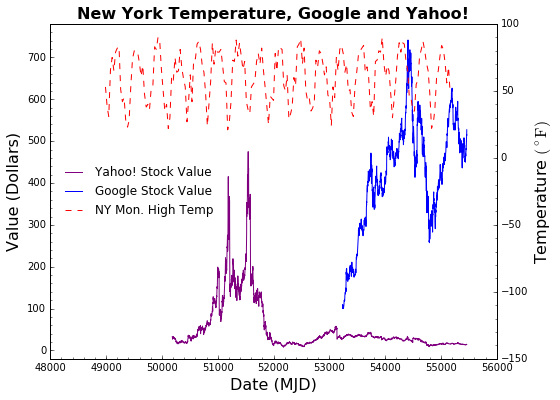

In [99]:
fs=16
fig, ax1 = plt.subplots(figsize=[8,6])

lns1 = ax1.plot(yahoo_t, yahoo_v, 'purple', label='Yahoo! Stock Value')
lns2 = ax1.plot(google_t, google_v, 'b-', label='Google Stock Value')
ax1.set_xlabel('Date (MJD)', fontsize=fs)
ax1.set_ylabel('Value (Dollars)', fontsize=fs)

ax1.set_ylim([-20, 780])
ax1.set_xlim([49000, 55000])

# add minor ticks
ax1.xaxis.set_minor_locator(MultipleLocator(200))
ax1.yaxis.set_minor_locator(MultipleLocator(20))

# set font for title
font = {'family': 'sans-serif','color':  'black', 
        'weight': 'bold','size': fs}
ax1.set_title('New York Temperature, Google and Yahoo!', fontdict=font)

# turn off major and minor ticks from upper x axis
ax1.tick_params(axis='x', which='both', top='off')        

ax2 = ax1.twinx()
lns3 = ax2.plot(ny_t, ny_v, 'r--', label='NY Mon. High Temp')
ax2.set_ylabel('Temperature $(^\circ \mathrm{F})$', fontsize=fs)
ax2.set_ylim([-150, 100])
ax2.yaxis.set_minor_locator(MultipleLocator(10))

# add legend
lns = lns1+lns2+lns3
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc='center left', frameon=False)

plt.show()

# #3 Generic "Brushing" code

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Read dataset with many rows and multiple columns (variables/parameters).

In [2]:
data_dir = 'hw_2_data/'
filename = data_dir + 'flowers.csv'

In [16]:
!tail -n 5 hw_2_data/flowers.csv

6.7,3.0,5.2,2.3,virginica
6.3,2.5,5.0,1.9,virginica
6.5,3.0,5.2,2.0,virginica
6.2,3.4,5.4,2.3,virginica
5.9,3.0,5.1,1.8,virginica


In [36]:
# datatype
dt = [('sepalLength', 'f4'), ('sepalWidth', 'f4'),
     ('petalLength', 'f4'), ('petalWidth', 'f4'), 
      ('species', 'S10')]

names = ['sepalLength', 'sepalWidth', 'petalLength', 'petalWidth', 'species']
formats = ['f4', 'f4', 'f4', 'f4', 'S10']
dt = {'names': names, 'formats':formats}
# dataset
ds = np.loadtxt(filename, delimiter=',', skiprows=1, dtype=dt)

Make subplots

In [37]:
setosa_ind = ds['species'] == b'setosa'
versicolor_ind = ds['species'] == b'versicolor'
virginica_ind = ds['species'] == b'virginica'

In [44]:
for i, var_i in enumerate(names):
    print(i, var_i)

0 sepalLength
1 sepalWidth
2 petalLength
3 petalWidth
4 species


In [39]:
# ds['sepalLength'][setosa_ind]

Create subplot 

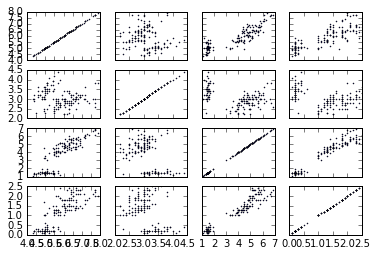

In [47]:
f, axes = plt.subplots(4, 4, sharey='row', sharex='col')
for i, var_i in enumerate(names[:4]):
    for j, var_j in enumerate(names[:4]):
        data_i = ds[var_i]
        data_j = ds[var_j]
        axes[i, j].plot(data_j, data_i, 'o', markersize=1)